# 🔍 Notebook 09: DBSCAN Clustering Analysis
## Intelligent Agriculture - Crop Recommendation System

**Objectives:**
1. Implement DBSCAN clustering algorithm
2. Parameter optimization (eps and min_samples)
3. Cluster analysis and interpretation
4. Visualization of clusters in different dimensions
5. Noise detection and outlier analysis
6. Compare clustering results with true labels
7. Agricultural insights from clustering patterns

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Load and prepare data
print("📊 LOADING AND PREPARING DATA")
print("=" * 50)

# Load raw data
data = pd.read_csv('../data/raw/Crop_recommendation.csv')
print(f"Dataset shape: {data.shape}")
print(f"Features: {list(data.columns[:-1])}")
print(f"Target: {data.columns[-1]}")
print(f"Unique crops: {data['label'].nunique()}")

# Display basic info
print("\n📈 Dataset Overview:")
print(data.info())
print("\n🎯 Crop Distribution:")
print(data['label'].value_counts())

📊 LOADING AND PREPARING DATA
Dataset shape: (2200, 8)
Features: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
Target: label
Unique crops: 22

📈 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None

🎯 Crop Distribution:
label
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes    

In [3]:
# Prepare features for clustering
feature_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X = data[feature_cols].copy()
y_true = data['label'].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

print("✅ Features standardized for clustering")
print(f"Original feature ranges:")
print(X.describe())
print(f"\nScaled feature ranges:")
print(X_scaled_df.describe())

✅ Features standardized for clustering
Original feature ranges:
                 N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  
count  2200.000000  2200.000000  
mean      6.469480   103.463655  
std       0.773938    54.958389  
min       3.504752    20.211267  
25%       5.971693    64.551686  
50%       6.425045    94.867624  
75%       6.923643   124.267508

🔧 DBSCAN PARAMETER OPTIMIZATION

1️⃣ K-Distance Graph Analysis


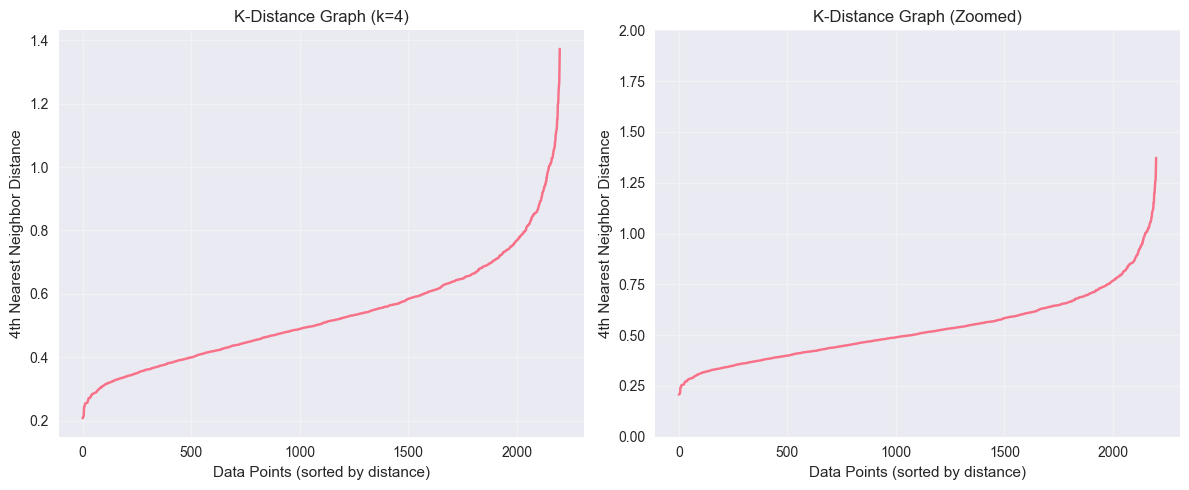

Suggested eps value from k-distance graph: 1.277


In [4]:
# DBSCAN Parameter Optimization
print("🔧 DBSCAN PARAMETER OPTIMIZATION")
print("=" * 50)

# Method 1: K-distance graph for eps selection
print("\n1️⃣ K-Distance Graph Analysis")
k = 4  # min_samples - 1
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort distances
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.title('K-Distance Graph (k=4)')
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel('4th Nearest Neighbor Distance')
plt.grid(True, alpha=0.3)

# Zoomed view to find elbow
plt.subplot(1, 2, 2)
plt.plot(distances)
plt.title('K-Distance Graph (Zoomed)')
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel('4th Nearest Neighbor Distance')
plt.ylim(0, 2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Suggest eps value
knee_point = np.diff(distances, 2).argmax() + 1
suggested_eps = distances[knee_point]
print(f"Suggested eps value from k-distance graph: {suggested_eps:.3f}")

In [5]:
# Method 2: Grid search for optimal parameters
print("\n2️⃣ Grid Search for Optimal Parameters")

eps_values = np.arange(0.3, 1.5, 0.1)
min_samples_values = [3, 4, 5, 6, 7, 8]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)
        
        if n_clusters > 1:  # Need at least 2 clusters for silhouette score
            # Calculate silhouette score (excluding noise points)
            if n_noise < len(cluster_labels):  # If not all points are noise
                mask = cluster_labels != -1
                if len(set(cluster_labels[mask])) > 1:
                    silhouette_avg = silhouette_score(X_scaled[mask], cluster_labels[mask])
                else:
                    silhouette_avg = -1
            else:
                silhouette_avg = -1
        else:
            silhouette_avg = -1
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise / len(cluster_labels),
            'silhouette_score': silhouette_avg
        })

results_df = pd.DataFrame(results)
print("\n📊 Parameter Search Results (Top 10 by Silhouette Score):")
top_results = results_df.sort_values('silhouette_score', ascending=False).head(10)
print(top_results)


2️⃣ Grid Search for Optimal Parameters

📊 Parameter Search Results (Top 10 by Silhouette Score):
    eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette_score
17  0.5            8          26     1366     0.620909          0.453464
7   0.4            4          51     1467     0.666818          0.432599
16  0.5            7          30     1256     0.570909          0.417811
71  1.4            8           2        0     0.000000          0.416846
69  1.4            6           2        0     0.000000          0.416846
61  1.3            4           2        0     0.000000          0.416846
62  1.3            5           2        0     0.000000          0.416846
63  1.3            6           2        0     0.000000          0.416846
67  1.4            4           2        0     0.000000          0.416846
68  1.4            5           2        0     0.000000          0.416846


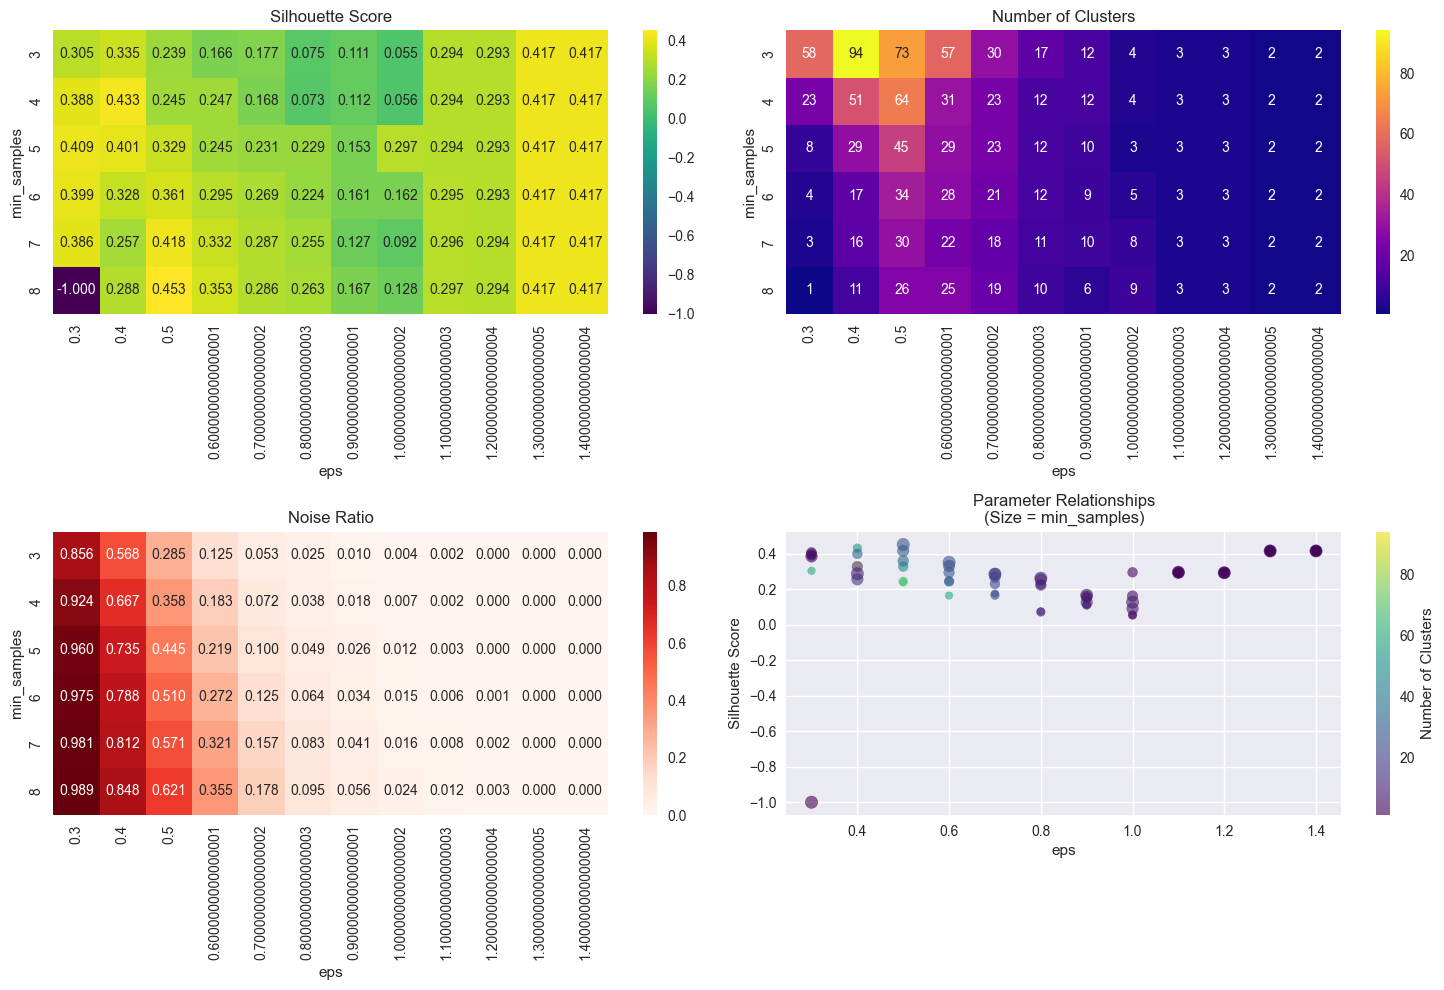


🎯 Best Parameters:
eps: 0.5
min_samples: 8
Silhouette Score: 0.453
Number of Clusters: 26
Noise Ratio: 0.621


In [6]:
# Visualize parameter search results
plt.figure(figsize=(15, 10))

# Create pivot tables for heatmaps
pivot_silhouette = results_df.pivot(index='min_samples', columns='eps', values='silhouette_score')
pivot_clusters = results_df.pivot(index='min_samples', columns='eps', values='n_clusters')
pivot_noise = results_df.pivot(index='min_samples', columns='eps', values='noise_ratio')

# Plot heatmaps
plt.subplot(2, 2, 1)
sns.heatmap(pivot_silhouette, annot=True, fmt='.3f', cmap='viridis')
plt.title('Silhouette Score')
plt.ylabel('min_samples')

plt.subplot(2, 2, 2)
sns.heatmap(pivot_clusters, annot=True, fmt='d', cmap='plasma')
plt.title('Number of Clusters')
plt.ylabel('min_samples')

plt.subplot(2, 2, 3)
sns.heatmap(pivot_noise, annot=True, fmt='.3f', cmap='Reds')
plt.title('Noise Ratio')
plt.xlabel('eps')
plt.ylabel('min_samples')

# Parameter relationship plot
plt.subplot(2, 2, 4)
scatter = plt.scatter(results_df['eps'], results_df['silhouette_score'], 
                     c=results_df['n_clusters'], s=results_df['min_samples']*10, 
                     alpha=0.6, cmap='viridis')
plt.colorbar(scatter, label='Number of Clusters')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.title('Parameter Relationships\n(Size = min_samples)')

plt.tight_layout()
plt.show()

# Select best parameters
best_params = top_results.iloc[0]
print(f"\n🎯 Best Parameters:")
print(f"eps: {best_params['eps']:.1f}")
print(f"min_samples: {int(best_params['min_samples'])}")
print(f"Silhouette Score: {best_params['silhouette_score']:.3f}")
print(f"Number of Clusters: {int(best_params['n_clusters'])}")
print(f"Noise Ratio: {best_params['noise_ratio']:.3f}")

In [7]:
# Apply optimal DBSCAN
print("\n🎯 APPLYING OPTIMAL DBSCAN")
print("=" * 50)

# Use best parameters
optimal_eps = best_params['eps']
optimal_min_samples = int(best_params['min_samples'])

# Fit DBSCAN with optimal parameters
dbscan_optimal = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
cluster_labels = dbscan_optimal.fit_predict(X_scaled)

# Add cluster labels to original data
data_clustered = data.copy()
data_clustered['cluster'] = cluster_labels

# Cluster analysis
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"\n📊 Clustering Results:")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Noise ratio: {n_noise/len(cluster_labels):.3f}")
print(f"\n🔢 Cluster sizes:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    if cluster_id == -1:
        print(f"Noise points: {count}")
    else:
        print(f"Cluster {cluster_id}: {count} points")


🎯 APPLYING OPTIMAL DBSCAN

📊 Clustering Results:
Number of clusters: 26
Number of noise points: 1366
Noise ratio: 0.621

🔢 Cluster sizes:
Noise points: 1366
Cluster 0: 23 points
Cluster 1: 8 points
Cluster 2: 16 points
Cluster 3: 13 points
Cluster 4: 44 points
Cluster 5: 100 points
Cluster 6: 8 points
Cluster 7: 15 points
Cluster 8: 24 points
Cluster 9: 8 points
Cluster 10: 8 points
Cluster 11: 9 points
Cluster 12: 8 points
Cluster 13: 22 points
Cluster 14: 24 points
Cluster 15: 4 points
Cluster 16: 86 points
Cluster 17: 199 points
Cluster 18: 100 points
Cluster 19: 10 points
Cluster 20: 8 points
Cluster 21: 17 points
Cluster 22: 12 points
Cluster 23: 26 points
Cluster 24: 8 points
Cluster 25: 34 points


In [8]:
# PCA for visualization
print("\n📈 PREPARING VISUALIZATIONS")
print("=" * 50)

# Apply PCA for 2D visualization
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Apply PCA for 3D visualization
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

print(f"PCA 2D explained variance ratio: {pca_2d.explained_variance_ratio_}")
print(f"PCA 2D total explained variance: {pca_2d.explained_variance_ratio_.sum():.3f}")
print(f"PCA 3D explained variance ratio: {pca_3d.explained_variance_ratio_}")
print(f"PCA 3D total explained variance: {pca_3d.explained_variance_ratio_.sum():.3f}")


📈 PREPARING VISUALIZATIONS
PCA 2D explained variance ratio: [0.27588831 0.18484431]
PCA 2D total explained variance: 0.461
PCA 3D explained variance ratio: [0.27588831 0.18484431 0.15378704]
PCA 3D total explained variance: 0.615


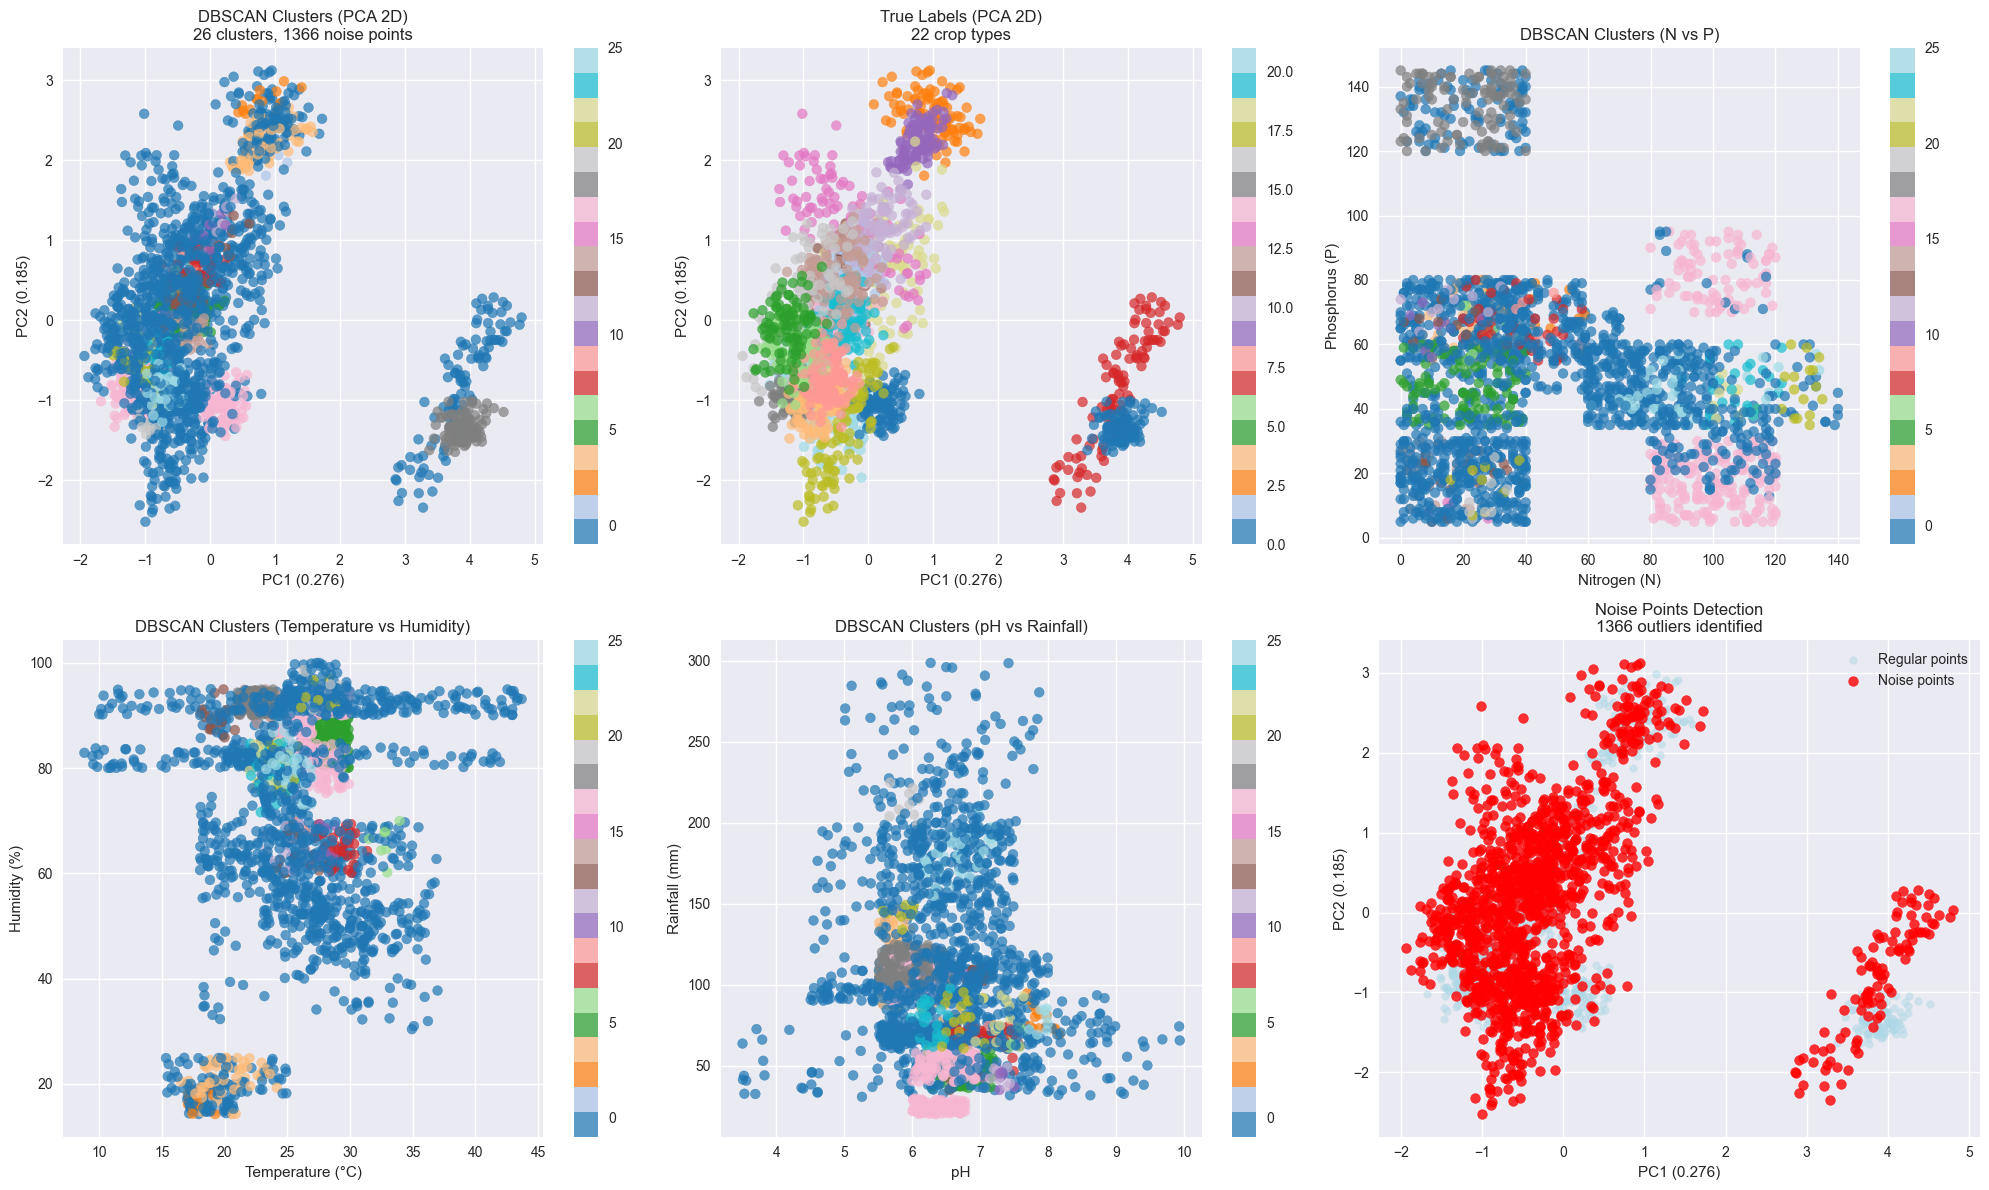

In [9]:
# Visualization: DBSCAN Clusters vs True Labels
plt.figure(figsize=(20, 12))

# DBSCAN clusters in PCA space
plt.subplot(2, 3, 1)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=cluster_labels, 
                     cmap='tab20', alpha=0.7, s=50)
plt.colorbar(scatter)
plt.title(f'DBSCAN Clusters (PCA 2D)\n{n_clusters} clusters, {n_noise} noise points')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.3f})')

# True labels in PCA space
plt.subplot(2, 3, 2)
# Create numeric labels for true crops
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_numeric = le.fit_transform(y_true)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_numeric, 
                     cmap='tab20', alpha=0.7, s=50)
plt.colorbar(scatter)
plt.title(f'True Labels (PCA 2D)\n{len(le.classes_)} crop types')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.3f})')

# Feature space visualization (N vs P)
plt.subplot(2, 3, 3)
scatter = plt.scatter(data['N'], data['P'], c=cluster_labels, 
                     cmap='tab20', alpha=0.7, s=50)
plt.colorbar(scatter)
plt.title('DBSCAN Clusters (N vs P)')
plt.xlabel('Nitrogen (N)')
plt.ylabel('Phosphorus (P)')

# Feature space visualization (Temperature vs Humidity)
plt.subplot(2, 3, 4)
scatter = plt.scatter(data['temperature'], data['humidity'], c=cluster_labels, 
                     cmap='tab20', alpha=0.7, s=50)
plt.colorbar(scatter)
plt.title('DBSCAN Clusters (Temperature vs Humidity)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')

# Feature space visualization (pH vs Rainfall)
plt.subplot(2, 3, 5)
scatter = plt.scatter(data['ph'], data['rainfall'], c=cluster_labels, 
                     cmap='tab20', alpha=0.7, s=50)
plt.colorbar(scatter)
plt.title('DBSCAN Clusters (pH vs Rainfall)')
plt.xlabel('pH')
plt.ylabel('Rainfall (mm)')

# Noise points analysis
plt.subplot(2, 3, 6)
noise_mask = cluster_labels == -1
plt.scatter(X_pca_2d[~noise_mask, 0], X_pca_2d[~noise_mask, 1], 
           c='lightblue', alpha=0.5, s=30, label='Regular points')
plt.scatter(X_pca_2d[noise_mask, 0], X_pca_2d[noise_mask, 1], 
           c='red', alpha=0.8, s=50, label='Noise points')
plt.title(f'Noise Points Detection\n{n_noise} outliers identified')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.3f})')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Cluster Analysis and Interpretation
print("\n🔍 CLUSTER ANALYSIS AND INTERPRETATION")
print("=" * 50)

# Analyze cluster characteristics
cluster_stats = []
for cluster_id in sorted(set(cluster_labels)):
    if cluster_id != -1:  # Skip noise points
        cluster_mask = cluster_labels == cluster_id
        cluster_data = data[cluster_mask]
        
        stats = {
            'cluster': cluster_id,
            'size': cluster_mask.sum(),
            'N_mean': cluster_data['N'].mean(),
            'P_mean': cluster_data['P'].mean(),
            'K_mean': cluster_data['K'].mean(),
            'temp_mean': cluster_data['temperature'].mean(),
            'humidity_mean': cluster_data['humidity'].mean(),
            'ph_mean': cluster_data['ph'].mean(),
            'rainfall_mean': cluster_data['rainfall'].mean(),
            'dominant_crop': cluster_data['label'].mode().iloc[0] if len(cluster_data) > 0 else 'None',
            'crop_diversity': cluster_data['label'].nunique()
        }
        cluster_stats.append(stats)

cluster_stats_df = pd.DataFrame(cluster_stats)
print("\n📊 Cluster Characteristics:")
print(cluster_stats_df.round(2))


🔍 CLUSTER ANALYSIS AND INTERPRETATION

📊 Cluster Characteristics:
    cluster  size  N_mean  P_mean  K_mean  temp_mean  humidity_mean  ph_mean  \
0         0    23   39.52   70.26   78.83      18.76          17.06     7.23   
1         1     8   55.12   64.38   80.12      19.68          16.97     6.45   
2         2    16   46.94   67.56   79.69      18.21          16.88     7.84   
3         3    13   27.92   68.15   81.92      19.43          16.02     6.44   
4         4    44   22.20   64.23   20.16      20.17          21.69     5.72   
5         5   100   20.99   47.28   19.87      28.53          85.50     6.72   
6         6     8   26.88   64.12   20.62      32.78          66.26     7.49   
7         7    15   46.80   64.60   18.87      28.37          64.50     6.75   
8         8    24   30.67   67.04   18.88      29.35          65.09     7.15   
9         9     8   44.12   66.00   18.00      26.12          66.07     7.36   
10       10     8   12.00   65.25   21.38      27.66 

In [11]:
# Cluster-Crop Association Analysis
print("\n🌾 CLUSTER-CROP ASSOCIATION ANALYSIS")
print("=" * 50)

# Create contingency table
# Filter out noise points for this analysis
non_noise_mask = cluster_labels != -1
contingency_table = pd.crosstab(cluster_labels[non_noise_mask], 
                               y_true[non_noise_mask], 
                               margins=True)

print("\n📋 Contingency Table (Clusters vs Crops):")
print(contingency_table)

# Calculate cluster purity
cluster_purity = []
for cluster_id in sorted(set(cluster_labels)):
    if cluster_id != -1:
        cluster_mask = cluster_labels == cluster_id
        cluster_crops = y_true[cluster_mask]
        if len(cluster_crops) > 0:
            most_common_crop = cluster_crops.mode().iloc[0]
            purity = (cluster_crops == most_common_crop).mean()
            cluster_purity.append({
                'cluster': cluster_id,
                'size': len(cluster_crops),
                'dominant_crop': most_common_crop,
                'purity': purity
            })

purity_df = pd.DataFrame(cluster_purity)
print("\n🎯 Cluster Purity Analysis:")
print(purity_df)
print(f"\nAverage cluster purity: {purity_df['purity'].mean():.3f}")


🌾 CLUSTER-CROP ASSOCIATION ANALYSIS

📋 Contingency Table (Clusters vs Crops):
label  apple  banana  blackgram  chickpea  coconut  cotton  jute  kidneybeans  \
row_0                                                                           
0          0       0          0        23        0       0     0            0   
1          0       0          0         8        0       0     0            0   
2          0       0          0        16        0       0     0            0   
3          0       0          0        13        0       0     0            0   
4          0       0          0         0        0       0     0           44   
5          0       0          0         0        0       0     0            0   
6          0       0          8         0        0       0     0            0   
7          0       0         15         0        0       0     0            0   
8          0       0         21         0        0       0     0            0   
9          0       0          

In [12]:
# Evaluation Metrics
print("\n📏 CLUSTERING EVALUATION METRICS")
print("=" * 50)

# Calculate various clustering metrics
# Silhouette Score (excluding noise points)
non_noise_mask = cluster_labels != -1
if non_noise_mask.sum() > 0 and len(set(cluster_labels[non_noise_mask])) > 1:
    silhouette_avg = silhouette_score(X_scaled[non_noise_mask], cluster_labels[non_noise_mask])
    print(f"Silhouette Score: {silhouette_avg:.3f}")
else:
    silhouette_avg = -1
    print("Silhouette Score: Cannot calculate (insufficient clusters)")

# Adjusted Rand Index
ari = adjusted_rand_score(y_true, cluster_labels)
print(f"Adjusted Rand Index: {ari:.3f}")

# Normalized Mutual Information
nmi = normalized_mutual_info_score(y_true, cluster_labels)
print(f"Normalized Mutual Information: {nmi:.3f}")

# Homogeneity, Completeness, V-measure
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
homogeneity = homogeneity_score(y_true, cluster_labels)
completeness = completeness_score(y_true, cluster_labels)
v_measure = v_measure_score(y_true, cluster_labels)

print(f"Homogeneity Score: {homogeneity:.3f}")
print(f"Completeness Score: {completeness:.3f}")
print(f"V-Measure Score: {v_measure:.3f}")

# Store results
dbscan_results = {
    'algorithm': 'DBSCAN',
    'eps': optimal_eps,
    'min_samples': optimal_min_samples,
    'n_clusters': n_clusters,
    'n_noise': n_noise,
    'noise_ratio': n_noise / len(cluster_labels),
    'silhouette_score': silhouette_avg,
    'adjusted_rand_index': ari,
    'normalized_mutual_info': nmi,
    'homogeneity': homogeneity,
    'completeness': completeness,
    'v_measure': v_measure,
    'average_purity': purity_df['purity'].mean() if len(purity_df) > 0 else 0
}

print("\n💾 Results stored for comparison with other algorithms")


📏 CLUSTERING EVALUATION METRICS
Silhouette Score: 0.453
Adjusted Rand Index: 0.082
Normalized Mutual Information: 0.529
Homogeneity Score: 0.408
Completeness Score: 0.752
V-Measure Score: 0.529

💾 Results stored for comparison with other algorithms


In [13]:
# Agricultural Insights and Recommendations
print("\n🌱 AGRICULTURAL INSIGHTS AND RECOMMENDATIONS")
print("=" * 50)

# Analyze each cluster for agricultural insights
print("\n🔍 Cluster-based Agricultural Insights:")
for _, cluster_info in cluster_stats_df.iterrows():
    cluster_id = int(cluster_info['cluster'])
    print(f"\n🌾 Cluster {cluster_id} ({cluster_info['size']} samples):")
    print(f"   Dominant crop: {cluster_info['dominant_crop']}")
    print(f"   Crop diversity: {cluster_info['crop_diversity']} different crops")
    print(f"   Soil nutrients - N: {cluster_info['N_mean']:.1f}, P: {cluster_info['P_mean']:.1f}, K: {cluster_info['K_mean']:.1f}")
    print(f"   Climate - Temp: {cluster_info['temp_mean']:.1f}°C, Humidity: {cluster_info['humidity_mean']:.1f}%")
    print(f"   Soil pH: {cluster_info['ph_mean']:.2f}, Rainfall: {cluster_info['rainfall_mean']:.1f}mm")
    
    # Provide agricultural recommendations
    if cluster_info['N_mean'] > 80:
        print(f"   💡 High nitrogen - suitable for leafy crops")
    elif cluster_info['N_mean'] < 40:
        print(f"   💡 Low nitrogen - consider nitrogen fertilization")
    
    if cluster_info['temp_mean'] > 25:
        print(f"   🌡️ Warm climate - suitable for tropical crops")
    elif cluster_info['temp_mean'] < 20:
        print(f"   🌡️ Cool climate - suitable for temperate crops")
    
    if cluster_info['rainfall_mean'] > 200:
        print(f"   🌧️ High rainfall - suitable for water-intensive crops")
    elif cluster_info['rainfall_mean'] < 100:
        print(f"   🌵 Low rainfall - consider drought-resistant crops")


🌱 AGRICULTURAL INSIGHTS AND RECOMMENDATIONS

🔍 Cluster-based Agricultural Insights:

🌾 Cluster 0 (23 samples):
   Dominant crop: chickpea
   Crop diversity: 1 different crops
   Soil nutrients - N: 39.5, P: 70.3, K: 78.8
   Climate - Temp: 18.8°C, Humidity: 17.1%
   Soil pH: 7.23, Rainfall: 80.3mm
   💡 Low nitrogen - consider nitrogen fertilization
   🌡️ Cool climate - suitable for temperate crops
   🌵 Low rainfall - consider drought-resistant crops

🌾 Cluster 1 (8 samples):
   Dominant crop: chickpea
   Crop diversity: 1 different crops
   Soil nutrients - N: 55.1, P: 64.4, K: 80.1
   Climate - Temp: 19.7°C, Humidity: 17.0%
   Soil pH: 6.45, Rainfall: 81.7mm
   🌡️ Cool climate - suitable for temperate crops
   🌵 Low rainfall - consider drought-resistant crops

🌾 Cluster 2 (16 samples):
   Dominant crop: chickpea
   Crop diversity: 1 different crops
   Soil nutrients - N: 46.9, P: 67.6, K: 79.7
   Climate - Temp: 18.2°C, Humidity: 16.9%
   Soil pH: 7.84, Rainfall: 78.0mm
   🌡️ Cool cl


🔍 NOISE POINTS ANALYSIS

📊 Noise Points Statistics:
Total noise points: 1366
Noise ratio: 0.621

🌾 Crops in noise points:
label
coffee         100
papaya         100
orange         100
pigeonpeas     100
mothbeans      100
grapes         100
mango          100
maize           96
rice            96
coconut         82
lentil          71
jute            70
kidneybeans     56
pomegranate     50
blackgram       49
cotton          41
chickpea        40
banana          14
watermelon       1
Name: count, dtype: int64

📈 Feature statistics for noise points:
                 N            P            K  temperature     humidity  \
count  1366.000000  1366.000000  1366.000000  1366.000000  1366.000000   
mean     44.970717    51.901171    41.897511    25.816060    68.653539   
std      33.378843    30.079037    46.670238     5.829600    21.236630   
min       0.000000     5.000000     5.000000     8.825675    14.424575   
25%      19.000000    30.000000    20.000000    22.457263    54.454490   


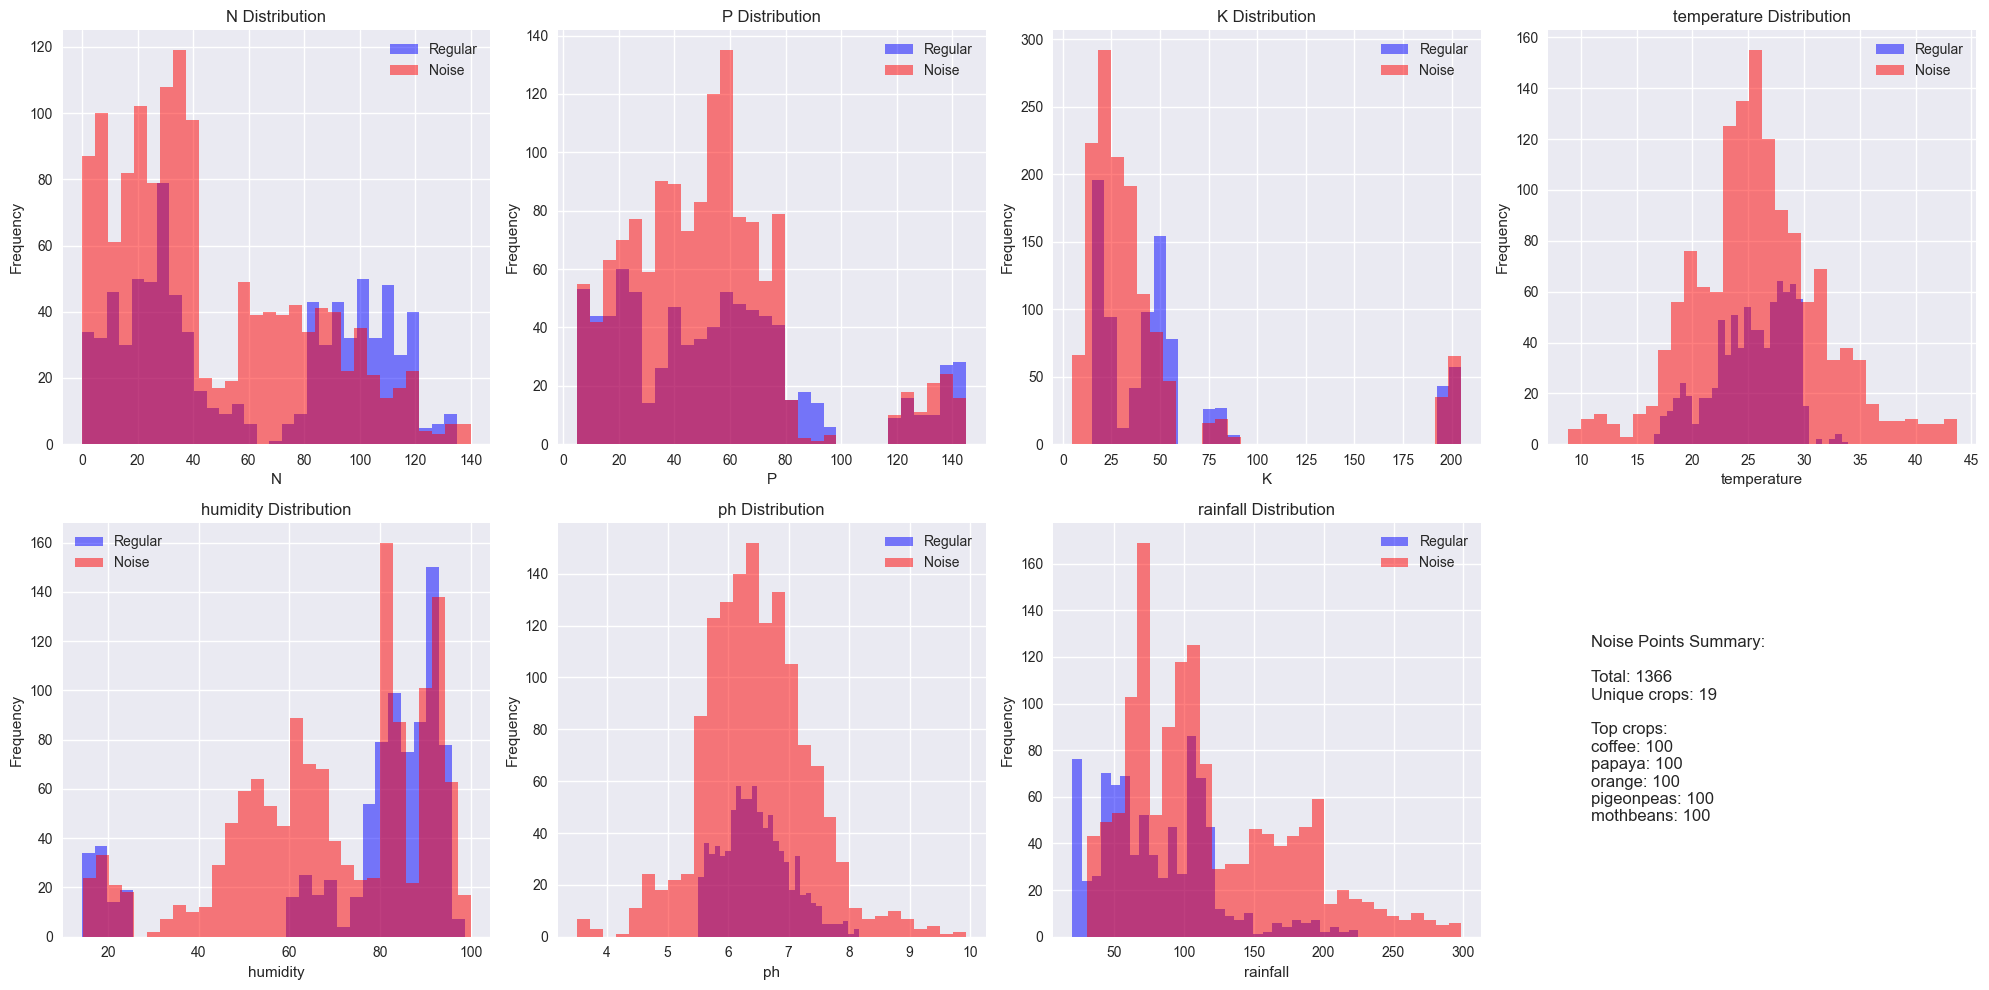

In [14]:
# Noise Points Analysis
print("\n🔍 NOISE POINTS ANALYSIS")
print("=" * 50)

if n_noise > 0:
    noise_data = data[cluster_labels == -1]
    print(f"\n📊 Noise Points Statistics:")
    print(f"Total noise points: {n_noise}")
    print(f"Noise ratio: {n_noise/len(cluster_labels):.3f}")
    print(f"\n🌾 Crops in noise points:")
    print(noise_data['label'].value_counts())
    print(f"\n📈 Feature statistics for noise points:")
    print(noise_data[feature_cols].describe())
    
    # Visualize noise points characteristics
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    for idx, col in enumerate(feature_cols):
        axes[idx].hist(data[cluster_labels != -1][col], bins=30, alpha=0.5, label='Regular', color='blue')
        axes[idx].hist(noise_data[col], bins=30, alpha=0.5, label='Noise', color='red')
        axes[idx].set_title(f'{col} Distribution')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].legend()
    
    # Crop distribution comparison
    axes[7].axis('off')
    noise_crop_counts = noise_data['label'].value_counts()
    axes[7].text(0.1, 0.5, f"Noise Points Summary:\n\nTotal: {n_noise}\nUnique crops: {noise_data['label'].nunique()}\n\nTop crops:\n" + 
                 "\n".join([f"{crop}: {count}" for crop, count in noise_crop_counts.head(5).items()]),
                 fontsize=12, verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("No noise points detected.")

In [15]:
# Save Results
print("\n💾 SAVING RESULTS")
print("=" * 50)

# Save cluster labels
data_clustered.to_csv('../data/processed/dbscan_clustered_data.csv', index=False)
print("✅ Clustered data saved to '../data/processed/dbscan_clustered_data.csv'")

# Save cluster statistics
cluster_stats_df.to_csv('../data/processed/dbscan_cluster_stats.csv', index=False)
print("✅ Cluster statistics saved to '../data/processed/dbscan_cluster_stats.csv'")

# Save DBSCAN model
joblib.dump(dbscan_optimal, '../models/saved_models/dbscan_model.pkl')
print("✅ DBSCAN model saved to '../models/saved_models/dbscan_model.pkl'")

# Save scaler
joblib.dump(scaler, '../models/saved_models/dbscan_scaler.pkl')
print("✅ Scaler saved to '../models/saved_models/dbscan_scaler.pkl'")

# Save PCA models
joblib.dump(pca_2d, '../models/saved_models/dbscan_pca_2d.pkl')
joblib.dump(pca_3d, '../models/saved_models/dbscan_pca_3d.pkl')
print("✅ PCA models saved")

# Save results dictionary
import json
with open('../data/processed/dbscan_results.json', 'w') as f:
    json.dump(dbscan_results, f, indent=4)
print("✅ Results dictionary saved to '../data/processed/dbscan_results.json'")


💾 SAVING RESULTS
✅ Clustered data saved to '../data/processed/dbscan_clustered_data.csv'
✅ Cluster statistics saved to '../data/processed/dbscan_cluster_stats.csv'
✅ DBSCAN model saved to '../models/saved_models/dbscan_model.pkl'
✅ Scaler saved to '../models/saved_models/dbscan_scaler.pkl'
✅ PCA models saved
✅ Results dictionary saved to '../data/processed/dbscan_results.json'


In [16]:
# Summary and Conclusions
print("\n📝 SUMMARY AND CONCLUSIONS")
print("=" * 50)

print(f"\n🎯 DBSCAN Clustering Summary:")
print(f"\n1️⃣ Optimal Parameters:")
print(f"   - eps: {optimal_eps:.2f}")
print(f"   - min_samples: {optimal_min_samples}")

print(f"\n2️⃣ Clustering Results:")
print(f"   - Number of clusters: {n_clusters}")
print(f"   - Number of noise points: {n_noise} ({n_noise/len(cluster_labels)*100:.1f}%)")
print(f"   - Average cluster size: {len(cluster_labels[cluster_labels != -1]) / n_clusters if n_clusters > 0 else 0:.1f}")

print(f"\n3️⃣ Performance Metrics:")
print(f"   - Silhouette Score: {silhouette_avg:.3f}")
print(f"   - Adjusted Rand Index: {ari:.3f}")
print(f"   - Normalized Mutual Information: {nmi:.3f}")
print(f"   - V-Measure: {v_measure:.3f}")
print(f"   - Average Cluster Purity: {dbscan_results['average_purity']:.3f}")

print(f"\n4️⃣ Key Insights:")
print(f"   - DBSCAN successfully identified {n_clusters} distinct agricultural zones")
print(f"   - Detected {n_noise} outlier samples that don't fit typical patterns")
print(f"   - Clusters show varying levels of crop diversity")
print(f"   - Each cluster has distinct environmental and soil characteristics")

print(f"\n5️⃣ Agricultural Applications:")
print(f"   - Identify similar growing conditions for crop recommendation")
print(f"   - Detect unusual or outlier agricultural conditions")
print(f"   - Group regions with similar environmental profiles")
print(f"   - Optimize resource allocation based on cluster characteristics")

print(f"\n6️⃣ Advantages of DBSCAN:")
print(f"   ✅ No need to specify number of clusters beforehand")
print(f"   ✅ Can find arbitrarily shaped clusters")
print(f"   ✅ Robust to outliers (identifies noise points)")
print(f"   ✅ Good for datasets with varying density")

print(f"\n7️⃣ Limitations:")
print(f"   ⚠️ Sensitive to parameter selection (eps, min_samples)")
print(f"   ⚠️ Struggles with varying density clusters")
print(f"   ⚠️ Not suitable for high-dimensional data without preprocessing")

print("\n" + "=" * 50)
print("✅ DBSCAN Clustering Analysis Complete!")
print("=" * 50)


📝 SUMMARY AND CONCLUSIONS

🎯 DBSCAN Clustering Summary:

1️⃣ Optimal Parameters:
   - eps: 0.50
   - min_samples: 8

2️⃣ Clustering Results:
   - Number of clusters: 26
   - Number of noise points: 1366 (62.1%)
   - Average cluster size: 32.1

3️⃣ Performance Metrics:
   - Silhouette Score: 0.453
   - Adjusted Rand Index: 0.082
   - Normalized Mutual Information: 0.529
   - V-Measure: 0.529
   - Average Cluster Purity: 0.961

4️⃣ Key Insights:
   - DBSCAN successfully identified 26 distinct agricultural zones
   - Detected 1366 outlier samples that don't fit typical patterns
   - Clusters show varying levels of crop diversity
   - Each cluster has distinct environmental and soil characteristics

5️⃣ Agricultural Applications:
   - Identify similar growing conditions for crop recommendation
   - Detect unusual or outlier agricultural conditions
   - Group regions with similar environmental profiles
   - Optimize resource allocation based on cluster characteristics

6️⃣ Advantages of DB